# Implementation of Neural Differential Equations for Time Series Analysis

In [38]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()


import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
from sklearn.metrics import mean_squared_error

## Defining some utility functions
----

In [39]:
def to_np(x):
    return x.detach().cpu().numpy()

In [40]:
def rk4(z0, t0, t1, f):
    """
    4th Order Runge-Kutta ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0) / h_max).max().item())

    h = (t1 - t0) / n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        k1 = h * f(z, t)
        k2 = h * f(z + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(z + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(z + k3, t + h)

        z = z + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        t = t + h
    return z

In [41]:
def ode_solve(z0, t0, t1, f):
    """Euler ODE initial value solver"""

    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

## Main Implementation
---

In [42]:
class ODEF(nn.Module):
    
    """Superclass of parameterized dynamics function"""
    
    def forward_with_grad(self, z, t, grad_outputs):
        
        """
        Method that computes the augmented dynamics. The augmented dynamics depends on the gradient 
        of the function(f - dynamics of the original system) wrt. its inputs (z,t) and parameters (theta). 
        In order to not have to specify them by hand for every new architecture, we will use torch.autograd.grad method.
        
        
        Compute f(t) and a*df/dz(t), a*df/dp(t), a*df/dt(t)
        f: dynamics of the system at time t
        z: state (actually the function we are looking for)
        p: parameters (theta)
        t: time
        
        
        The method first determines the batch_size based on the shape of z. 
        It then computes the forward pass by calling self.forward(z, t) to get the dynamics out. 
        The torch.autograd.grad method is then used to compute the gradients with respect to z, t, and the parameters. 
        The resulting gradients are expanded and normalized by the batch_size for consistency.
        
        Inputs:
        ------
            self: Refers to the instance of the ODEF class.
            z: The state tensor at a particular time. This tensor represents the state of the system we're modeling.
            t: The time tensor at which the dynamics are being evaluated.
            grad_outputs(list of dL/dz for each time point): The gradients of the loss with respect to the current output 
        
        
        
        
        Returns: 
        --------
            out: dynamics out (the value of f(t)), 
            gradients: 
                adfdz: a(t)*df/dz(t), 
                adfdt: a(t)*df/dt(t) and 
                adfdp: a(t)*(df/dp) 
                    

        """
        
        # Define the batch_size based on the shape of z.
        batch_size = z.shape[0]
        
        # Compute the dynamics of the system at the given state and time.
        out = self.forward(z, t)
        
        # The gradients of the loss(L) with respect to the current outputs. This is passed as a parameter 'a'.
        a = grad_outputs
        
        
        # Compute gradients using automatic differentiation. The torch.autograd.grad takes the following arguments:
                #outputs: A tuple of tensors for which gradients should be computed (in this case, just out).
                #inputs: A tuple of tensors with respect to which gradients should be computed (in this case, (z, t) + tuple(self.parameters())).
                #grad_outputs: The gradients of the outputs with respect to the current outputs (a in this case).
                #allow_unused: Allows for gradients to be unused if some inputs are not used in the computation.
                #retain_graph: Indicates whether to retain the computation graph for further backpropagation.
                
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        """Method to flatten all the parameters a function depends on"""
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [43]:
class ODEAdjoint(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        
        """
        This static method is responsible for the forward pass of the ODEAdjoint function. 
        It performs the forward pass of solving the ODE using the ode_solve function. 
        It creates a tensor z to store the solutions at each time step. 
        The z tensor is initialized with zeros and assigned z0 as the initial value. 
        It then iterates over the time steps and applies ode_solve to compute the state at each time step. 
        The resulting tensor z is stored in the context (ctx) for later use in the backward pass.
        
        Inputs: 
        - ctx: In PyTorch, ctx stands for "context" and is an object that is used to store information needed for the backward pass of an autograd function. 
               It is a required argument for both the forward and backward methods of the torch.autograd.Function class.
               It serves as a container to save and retrieve any tensors or other variables needed in the backward pass. 
               In the forward method, relevant information such as t, z, and flat_parameters is saved in the context 
               using ctx.save_for_backward().
        
        - z0 (initial state), 
        - t (time tensor),
        - flat_parameters (flattened parameters), 
        - func (the dynamics function). 
        
        
         
        Returns: z (states)

        """
        
        
        # Check whether the func variable is an instance of the ODEF class
        assert isinstance(func, ODEF)
        
        # Define the batch size and the shape of the state
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            # Initialize the tensor of states
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            
            # Define the initial value
            z[0] = z0
            
            # Iterate over the time steps and apply ode_solve to compute the state at each time step
            for i_t in range(time_len - 1):
                z0 = rk4(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0
        
        # Store information needed for the backward pass 
        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        
        # Return computed z-values at each time step
        return z

    @staticmethod
    def backward(ctx, dLdz):
        
        """
        Inputs:
        -------
        - ctx: 
        - dLdz - gradients of loss L with respect to states, dLdz.shape = (time_len, batch_size, *z_shape)
        
        
        Returns: values of adj_z, adj_t, adj_p at the time step t_0: adj_z.view(bs, *z_shape), adj_t, adj_p, None
        -------- 
                where: 
                 - adj_z: 'a' - adjoint state at time t_0
                 - adj_t: 'a_t' at time t_0
                 - adj_p: 'a_theta' at time t_0 (this is essentially used to update the parameters of dynamics function)
        
        
        This static method performs the backward pass of the ODEAdjoint function. 
        It takes in the gradient tensor dLdz and computes the gradients of the loss with respect to 
        the inputs (adj_z), time (adj_t), and parameters (adj_p). The method starts by retrieving 
        the saved tensors from the context, including t, z, and flat_parameters. 
        It initializes tensors for the adjoints: adj_z, adj_p, and adj_t. It then iterates backward 
        in time and computes the augmented dynamics for each time step using the augmented_dynamics function. 
        It adjusts the adjoints using direct gradients and solves the augmented system backwards using ode_solve.
        Finally, it adjusts the adjoints for the time step 0 and returns the computed gradients.
        """
        
        # Retrieve saved tensors from the context: function f(dynamics of system) and tensors: t, z, flat_parameters
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        
        # Define: time_len (number of time points), bs (batch_size), z_shape: if z=[z1,z2] ---> z_shape: [2]
        time_len, bs, *z_shape = z.size()
        
        # Get the total number of elements in the tensor z: (number of components: z_1, z_2,...)
        n_dim = np.prod(z_shape)
        
        # Get the number of parameters
        n_params = flat_parameters.size(0)
        
        
        #Let's define the dynamics of augmented system that will be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """Function that calculates the fynamics of augmented system
            
            Inputs: 
            -------
            aug_z_i: current augmented state [z_i, adj_z_i, 0, adj_t_i]
            t_i : current time point
            
            
            Returns: 
            -------
            [f(t_i), -a*dfdz, -a*dfdp, -adfdt]
            """
            
            # Extract z and a from augmented variable
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            
            with torch.set_grad_enabled(True):
                #Now, for each time step t_i, we want to detach z_i from the previous computational graph 
                #(to prevent gradients from flowing through previous steps) and reattach it to the current graph 
                #with the requires_grad_ method set to True. 
                #This is important because we are going to compute gradients with respect to z_i 
                #and perform further computations based on these gradients.

                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                
                #Some gradients might be None, so let's make sure we turn those into zeros
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)
        
        
        # Flatten dLdz for convenience
        dLdz = dLdz.view(time_len, bs, n_dim)  
        
        with torch.no_grad():
            # Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)


            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]
                

                # Adjusting adjoints with direct gradients
                adj_z = dLdz_i + adj_z
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = rk4(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            # Adjust 0-th time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
            
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [44]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

## Examples
---

### 1st example
---
$$
\frac{dz}{dt} = -z \quad \text{with} \quad z(0) 
$$


In [45]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(1, 1, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

class exponential_decayExample(LinearODEF):
    def __init__(self):
        super(exponential_decayExample, self).__init__(Tensor([[-0.05]]))

class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(1,1)/100.)

ode_true = NeuralODE(exponential_decayExample())
ode_trained = NeuralODE(RandomLinearODEF())

In [46]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(10, 15), parameters=None, wrt_t=False,
                      current_loss = None, plot_loss=False, losses=None, step=None, learning_rate = None):
    
    # Define a figure
    fig = plt.figure(figsize=figsize, dpi=150)

    # Add subplots to the figure
    ax1 = fig.add_subplot(211)  # 2 rows, 2 columns, plot number 1
    #ax2 = fig.add_subplot(222)  # 2 rows, 2 columns, plot number 2
    
    
    #print("obs.shape:",obs.shape)
    obs, t = to_np(obs), to_np(times)
    #z1 = obs[:, :, 0]
    #z2 = obs[:, :, 1]
    #ax2.scatter(z1, z2, s=10, label="True solution", alpha=0.3)

    #print(times)
    z = to_np(trajs)
    #ax2.plot(z[:, 0, 0], z[:, 0, 1], , lw=1.5, label=f"{parameters} |   loss {current_loss}   |   |lr:{learning_rate}   step: {step}", c="red") 
    
    #ax2.set_xlabel("$z_1(t)$", size=15)
    #ax2.set_ylabel("$z_2(t)$", size=15)
            
    if wrt_t:
        ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 0], c='lightgreen',s=10, label='true $z_1$')
        #ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 1], c='pink',s=10, label='true $z_2$')
        ax1.plot(times.detach().numpy().flatten(), z[:, :, 0], c='darkgreen', linestyle="-",linewidth=2,
                label=f"numerical $z_1$ {parameters} |   loss {current_loss}   |   |lr:{learning_rate}   step: {step}")
        #ax1.plot(times.detach().numpy().flatten(), z[:, :, 1], c='darkviolet', linestyle="-",linewidth=2, label='numerical $z_2$')
        ax1.set_xlabel('$t$', size=15)  
        
    if plot_loss:
        ax3 = fig.add_subplot(212)  # 2 rows, 1 column, plot number 2
        #x = np.arange(ith_step)
        ax3.plot(np.arange(len(losses)), losses, label="Loss")
        ax3.set_xlabel("$iteration$", size=15)
        ax3.set_ylabel("$Loss$", size=15)            
    
    
    # Show the plot
    plt.tight_layout()
    # Add a general legend below the subplots
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=15)
    plt.show()

In [47]:
def conduct_experiment(ode_true, ode_trained, z0, n_steps,
                       t_max, n_poins, min_delta_time, max_delta_time, max_points_num, 
                       wrt_t = False, plot_freq=10, optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.05),
                       scheduler = None, desired_loss = 0.01):
    # CREATE THE DATA
    index_np = np.arange(0, n_points, 1, dtype=np.int64)
    times_np = np.linspace(0, t_max, num=n_points)
    times = torch.from_numpy(times_np).to(z0)
    
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    #add random noise to the observation tensor
    obs = obs + torch.randn_like(obs) * 0.01

    
    def create_batch():
        """Function to get a mini_batch"""
        
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)
        
        # creates an index array by selecting a subset of indices from the index_np array
        # by filtering the indices where the corresponding times in times_np fall within the range (t0, t1). 
        # The permutation function shuffles the filtered indices randomly, and [:max_points_num] selects the first max_points_num indices. 
        # Finally, the sorted function is applied to ensure the indices are in ascending order.
        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_
    
    

    # Train Neural ODE
    #-----------------#
    # initialize the LOSS array
    LOSS = []
    mean_losses = []
    mean_current_loss = np.float64("inf")
    
    for i in range(1, n_steps + 1):

        #generate a mini-batch of observations and corresponding time values
        obs_, ts_ = create_batch()
        
        #compute z_ by passing the first observation obs_[0] and its corresponding time values ts_ 
        #through the ode_trained model. The return_whole_sequence=True ensures that the entire trajectory is returned.
        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        
        #compute the loss
        loss = F.mse_loss(z_, obs_.detach())  #The .detach() method is used to detach obs_ from the computational graph,
                                              #preventing gradients from flowing through it during backpropagation.
        LOSS.append(loss.item())
        
        if mean_current_loss <= desired_loss:
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
   
            plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                  parameters = ode_trained.state_dict(),
                                  wrt_t = True, plot_loss=True, losses=mean_losses, current_loss = mean_current_loss, step=i,
                                  learning_rate = lr)  # Display the plot
            
            break
        
        #reset optimizer gradients to zero
        optimizer.zero_grad()
        
        #propagate loss through the computation graph
        loss.backward(retain_graph=True)
        
        #update the model's parameters based on the computed gradients 
        optimizer.step()
        
        lr = optimizer.param_groups[0]['lr']
        if scheduler is not None: 
            scheduler.step()

        if i % plot_freq == 0:
            mean_current_loss = np.mean(LOSS)
            mean_losses.append(mean_current_loss)
            LOSS = []
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
            
            if i == n_steps: 
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                  parameters = ode_trained.state_dict(),
                                  wrt_t = True, plot_loss=True, losses=mean_losses, current_loss = mean_current_loss, step=i,
                                  learning_rate = lr)
            else: 
   
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                 parameters = ode_trained.state_dict(),
                                 wrt_t = True, current_loss=mean_current_loss, step=i, learning_rate = lr)
   
            clear_output(wait=True)

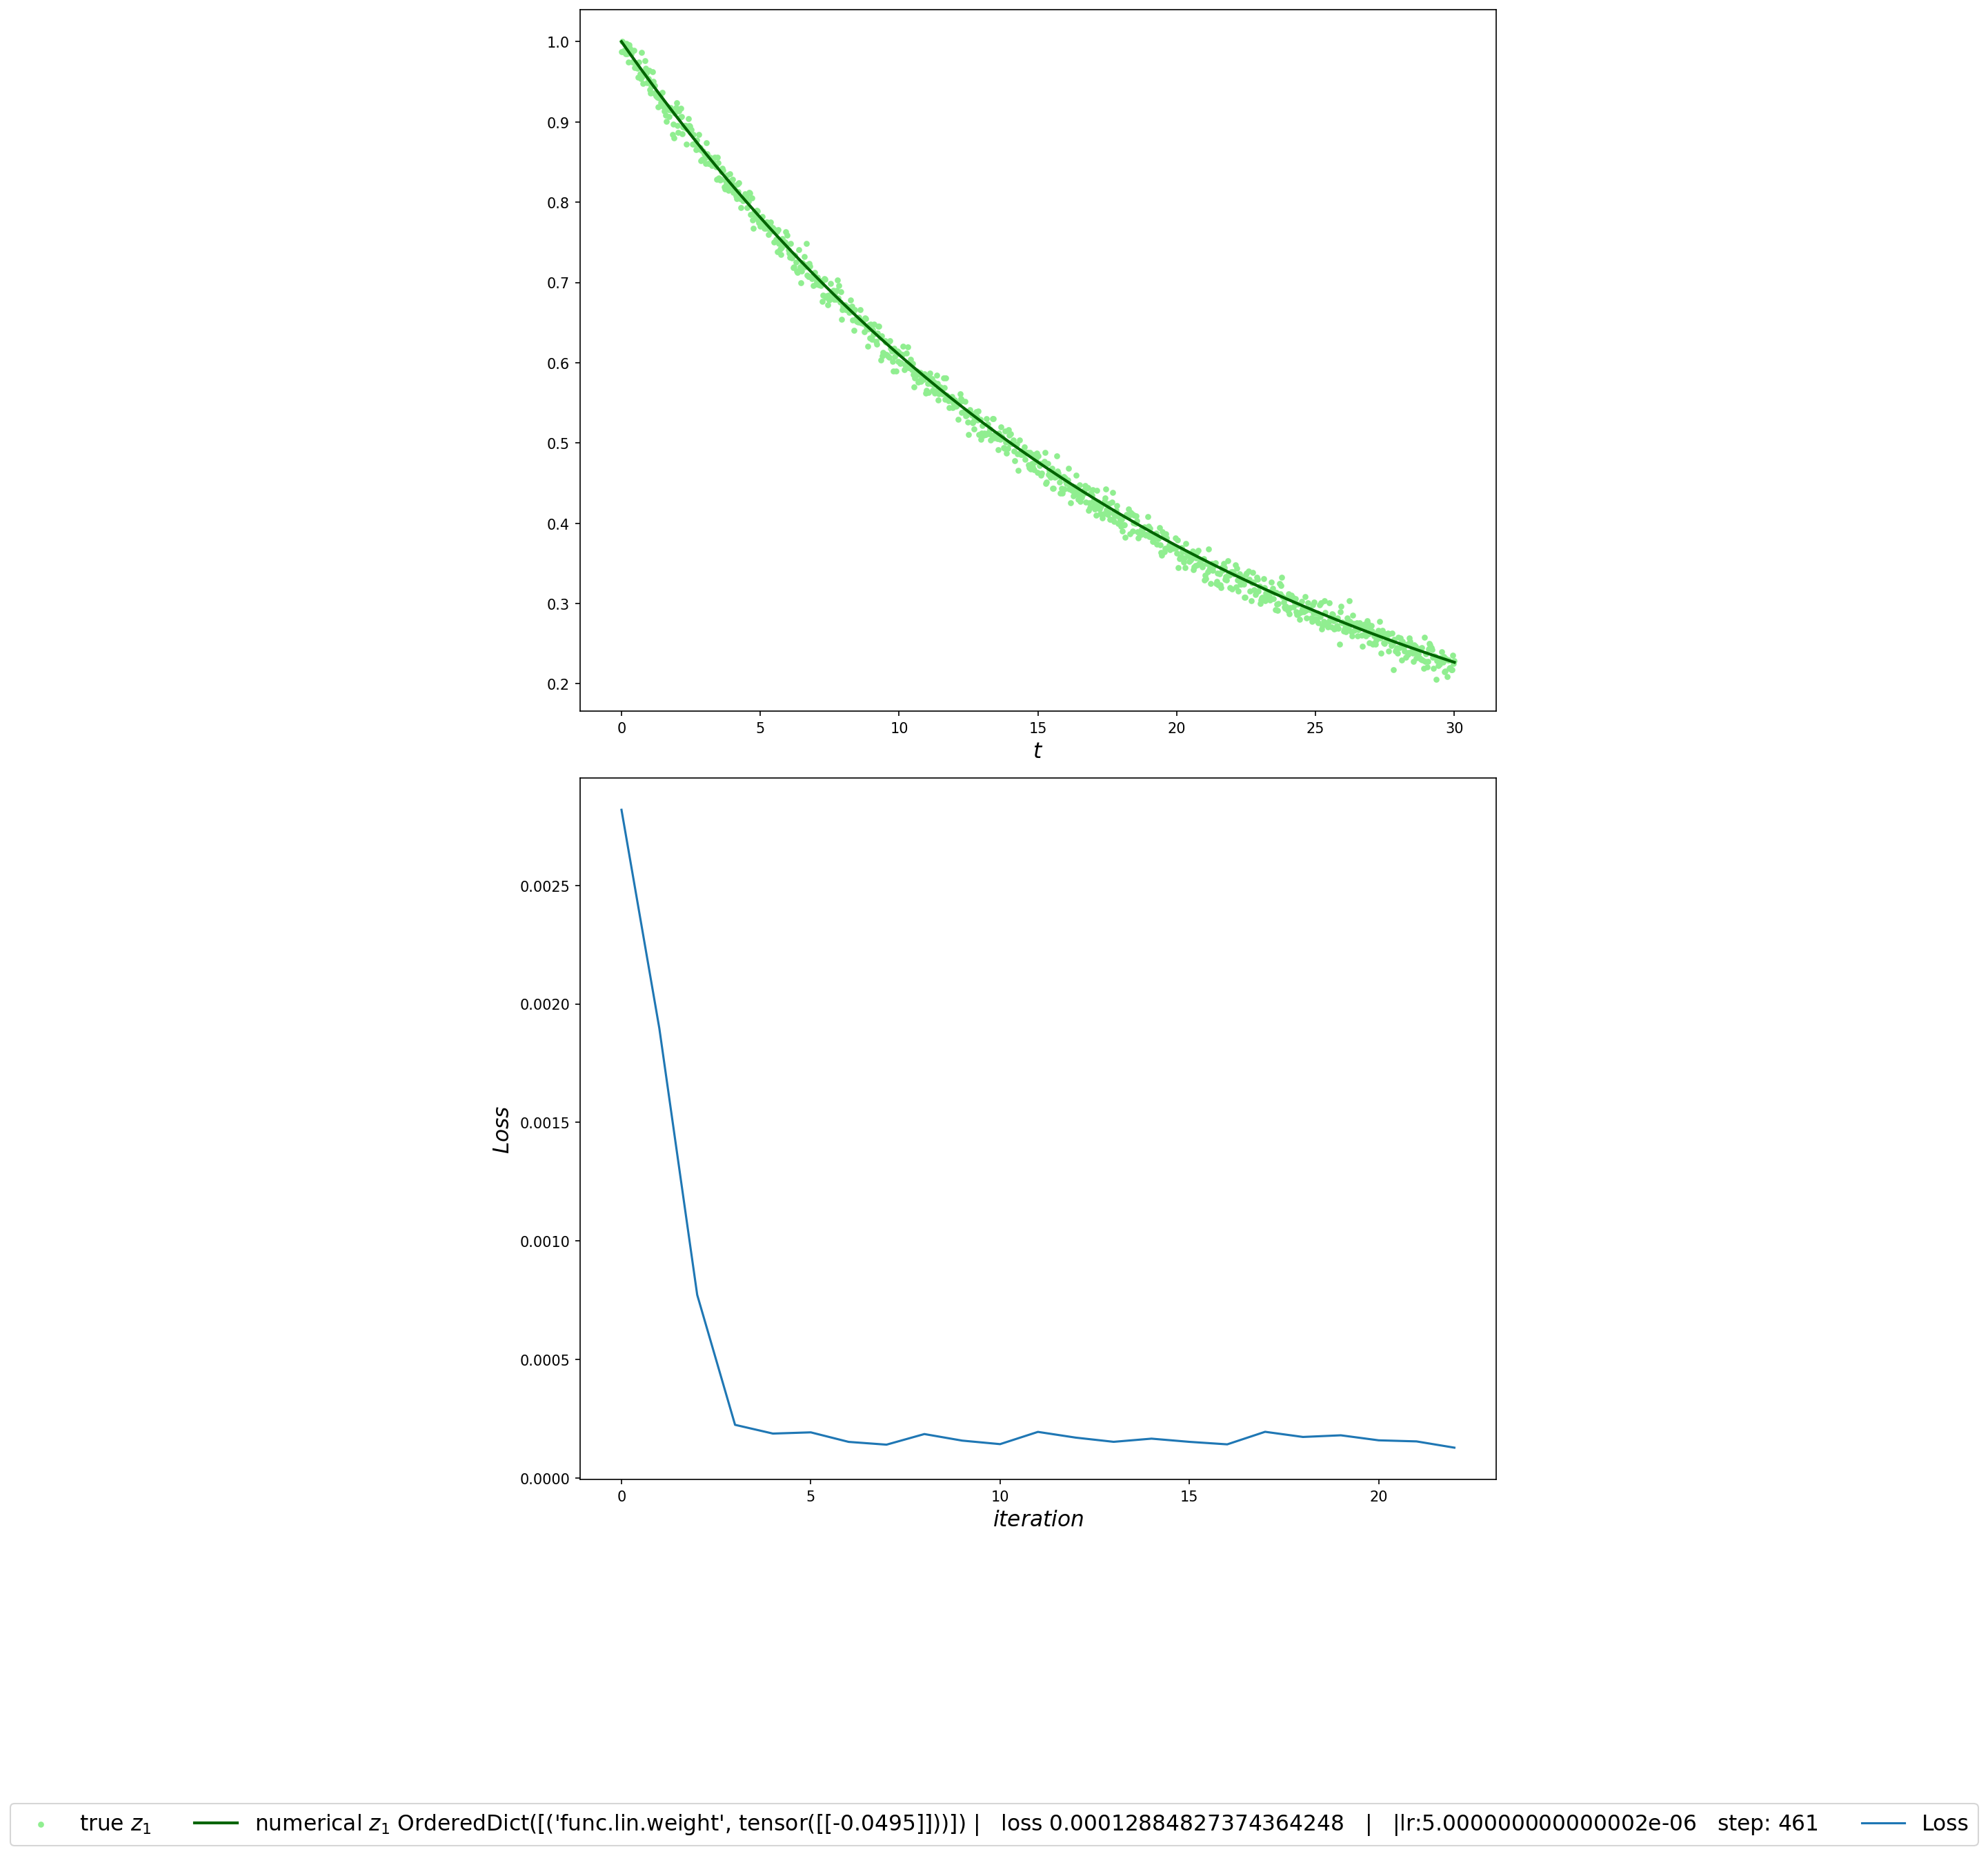

In [48]:
ode_true = NeuralODE(exponential_decayExample())
ode_trained = NeuralODE(RandomLinearODEF())

t_max = 30
n_points = 1000

# Get trajectory of random timespan
min_delta_time = 1.0
max_delta_time = 10
max_points_num = 256

#initial point
z0 = Variable(torch.Tensor([[1]]))

optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

conduct_experiment(ode_true=ode_true, 
                   ode_trained=ode_trained,
                   z0=z0,
                   n_steps=500,
                   t_max=t_max, 
                   n_poins=n_points, 
                   min_delta_time=min_delta_time, 
                   max_delta_time=max_delta_time,
                   max_points_num=max_points_num, 
                   wrt_t = True, plot_freq=20, optimizer = optimizer, scheduler = scheduler,
                   desired_loss = 1.3e-4)

#### Difference between true and trained parameters $\theta$
---

In [16]:
print("true parameters: ",ode_true.state_dict()["func.lin.weight"])
print("trained parameters: ",ode_trained.state_dict()["func.lin.weight"])
print("Absolute difference: ", np.abs(ode_true.state_dict()["func.lin.weight"] - ode_trained.state_dict()["func.lin.weight"]))

true parameters:  tensor([[-0.0500]])
trained parameters:  tensor([[-0.0500]])
Absolute difference:  tensor([[2.9363e-05]])


### 2nd example
---
$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z \quad \text{with} \quad  \begin{bmatrix}z_1\\z_2\end{bmatrix}(0) \begin{bmatrix}0.6\\0.3\end{bmatrix}
$$




In [31]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/1000)

ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

#### Training

In [32]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(20, 15), parameters=None, wrt_t=False,
                      current_loss = None, plot_loss=False, losses=None, step=None, learning_rate = None):
    
    # Define a figure
    fig = plt.figure(figsize=figsize, dpi=300)

    # Add subplots to the figure
    ax1 = fig.add_subplot(221)  # 2 rows, 2 columns, plot number 1
    ax2 = fig.add_subplot(222)  # 2 rows, 2 columns, plot number 2
    
    obs, t = to_np(obs), to_np(times)
    z1 = obs[:, :, 0]
    z2 = obs[:, :, 1]
    ax2.scatter(z1, z2, s=10, label="True solution")

    z = to_np(trajs)
    ax2.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5, label=f"{parameters} |   loss {current_loss}   |   |lr:{learning_rate}   step: {step}", c="red") 
    
    ax2.set_xlabel("$z_1(t)$", size=15)
    ax2.set_ylabel("$z_2(t)$", size=15)
            
    if wrt_t:
        ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 0], c='lightgreen',s=10, label='true $z_1$')
        ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 1], c='pink',s=10, label='true $z_2$')
        ax1.plot(times.detach().numpy().flatten(), z[:, :, 0], c='darkgreen', linestyle="-",linewidth=2, label='numerical $z_1$')
        ax1.plot(times.detach().numpy().flatten(), z[:, :, 1], c='darkviolet', linestyle="-",linewidth=2, label='numerical $z_2$')
        ax1.set_xlabel('$t$')  
        
    if plot_loss:
        ax3 = fig.add_subplot(212)  # 2 rows, 1 column, plot number 2
        #x = np.arange(ith_step)
        ax3.plot(np.arange(len(losses)), losses, label="Loss")
        ax3.set_xlabel("$iteration$", size=15)
        ax3.set_ylabel("$Loss$")            
    

    # Show the plot
    plt.tight_layout()
    # Add a general legend below the subplots
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=15)
    plt.show()

In [33]:
def conduct_experiment(ode_true, ode_trained, z0, n_steps,
                       t_max, n_poins, min_delta_time, max_delta_time, max_points_num, 
                       wrt_t = False, plot_freq=10, optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.05),
                       scheduler = None, desired_loss = 0.01):
    #CREATE THE DATA
    index_np = np.arange(0, n_points, 1, dtype=np.int64)
    times_np = np.linspace(0, t_max, num=n_points)
    #print("times_np.shape:", times_np.shape)
    times = torch.from_numpy(times_np).to(z0)
    #print("times:", times.size())
    
    
    
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    #add random noise to the observation tensor
    obs = obs + torch.randn_like(obs) * 0.01

    
    def create_batch():
        """Function to get a mini_batch"""
        
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)
        
        #creates an index array by selecting a subset of indices from the index_np array
        #by filtering the indices where the corresponding times in times_np fall within the range (t0, t1). 
        #The permutation function shuffles the filtered indices randomly, and [:max_points_num] selects the first max_points_num indices. 
        #Finally, the sorted function is applied to ensure the indices are in ascending order.
        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])
        #print("idx:", idx)
        #print("idx:", idx)

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    
    #Train Neural ODE
    #----------------#
    #initialize the LOSS array
    LOSS = []
    mean_losses = []
    mean_current_loss = np.float64("inf")
    
    for i in range(1, n_steps + 1):

        #generate a mini-batch of observations and corresponding time values
        obs_, ts_ = create_batch()
        
        #compute z_ by passing the first observation obs_[0] and its corresponding time values ts_ 
        #through the ode_trained model. The return_whole_sequence=True ensures that the entire trajectory is returned.
        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        
        #compute the loss
        loss = F.mse_loss(z_, obs_.detach())  #The .detach() method is used to detach obs_ from the computational graph,
                                              #preventing gradients from flowing through it during backpropagation.
        LOSS.append(loss.item())
        
        if mean_current_loss <= desired_loss:
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
   
            plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                  parameters = ode_trained.state_dict(),
                                  wrt_t = True, plot_loss=True, losses=mean_losses, current_loss = mean_current_loss, step=i,
                                  learning_rate = lr)  # Display the plot
            
            break
        
        #reset optimizer gradients to zero
        optimizer.zero_grad()
        
        #propagate loss through the computation graph
        loss.backward(retain_graph=True)
        
        #update the model's parameters based on the computed gradients 
        optimizer.step()
        
        lr = optimizer.param_groups[0]['lr']
        if scheduler is not None: 
            scheduler.step()

        if i % plot_freq == 0:
            mean_current_loss = np.mean(LOSS)
            mean_losses.append(mean_current_loss)
            LOSS = []
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
            
            if i == n_steps: 
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                  parameters = ode_trained.state_dict(),
                                  wrt_t = True, plot_loss=True, losses=mean_losses, current_loss = mean_current_loss, step=i,
                                  learning_rate = lr)
            else: 
   
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                 parameters = ode_trained.state_dict(),
                                 wrt_t = True, current_loss=mean_current_loss, step=i, learning_rate = lr)
                
   
            clear_output(wait=True)

In [35]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

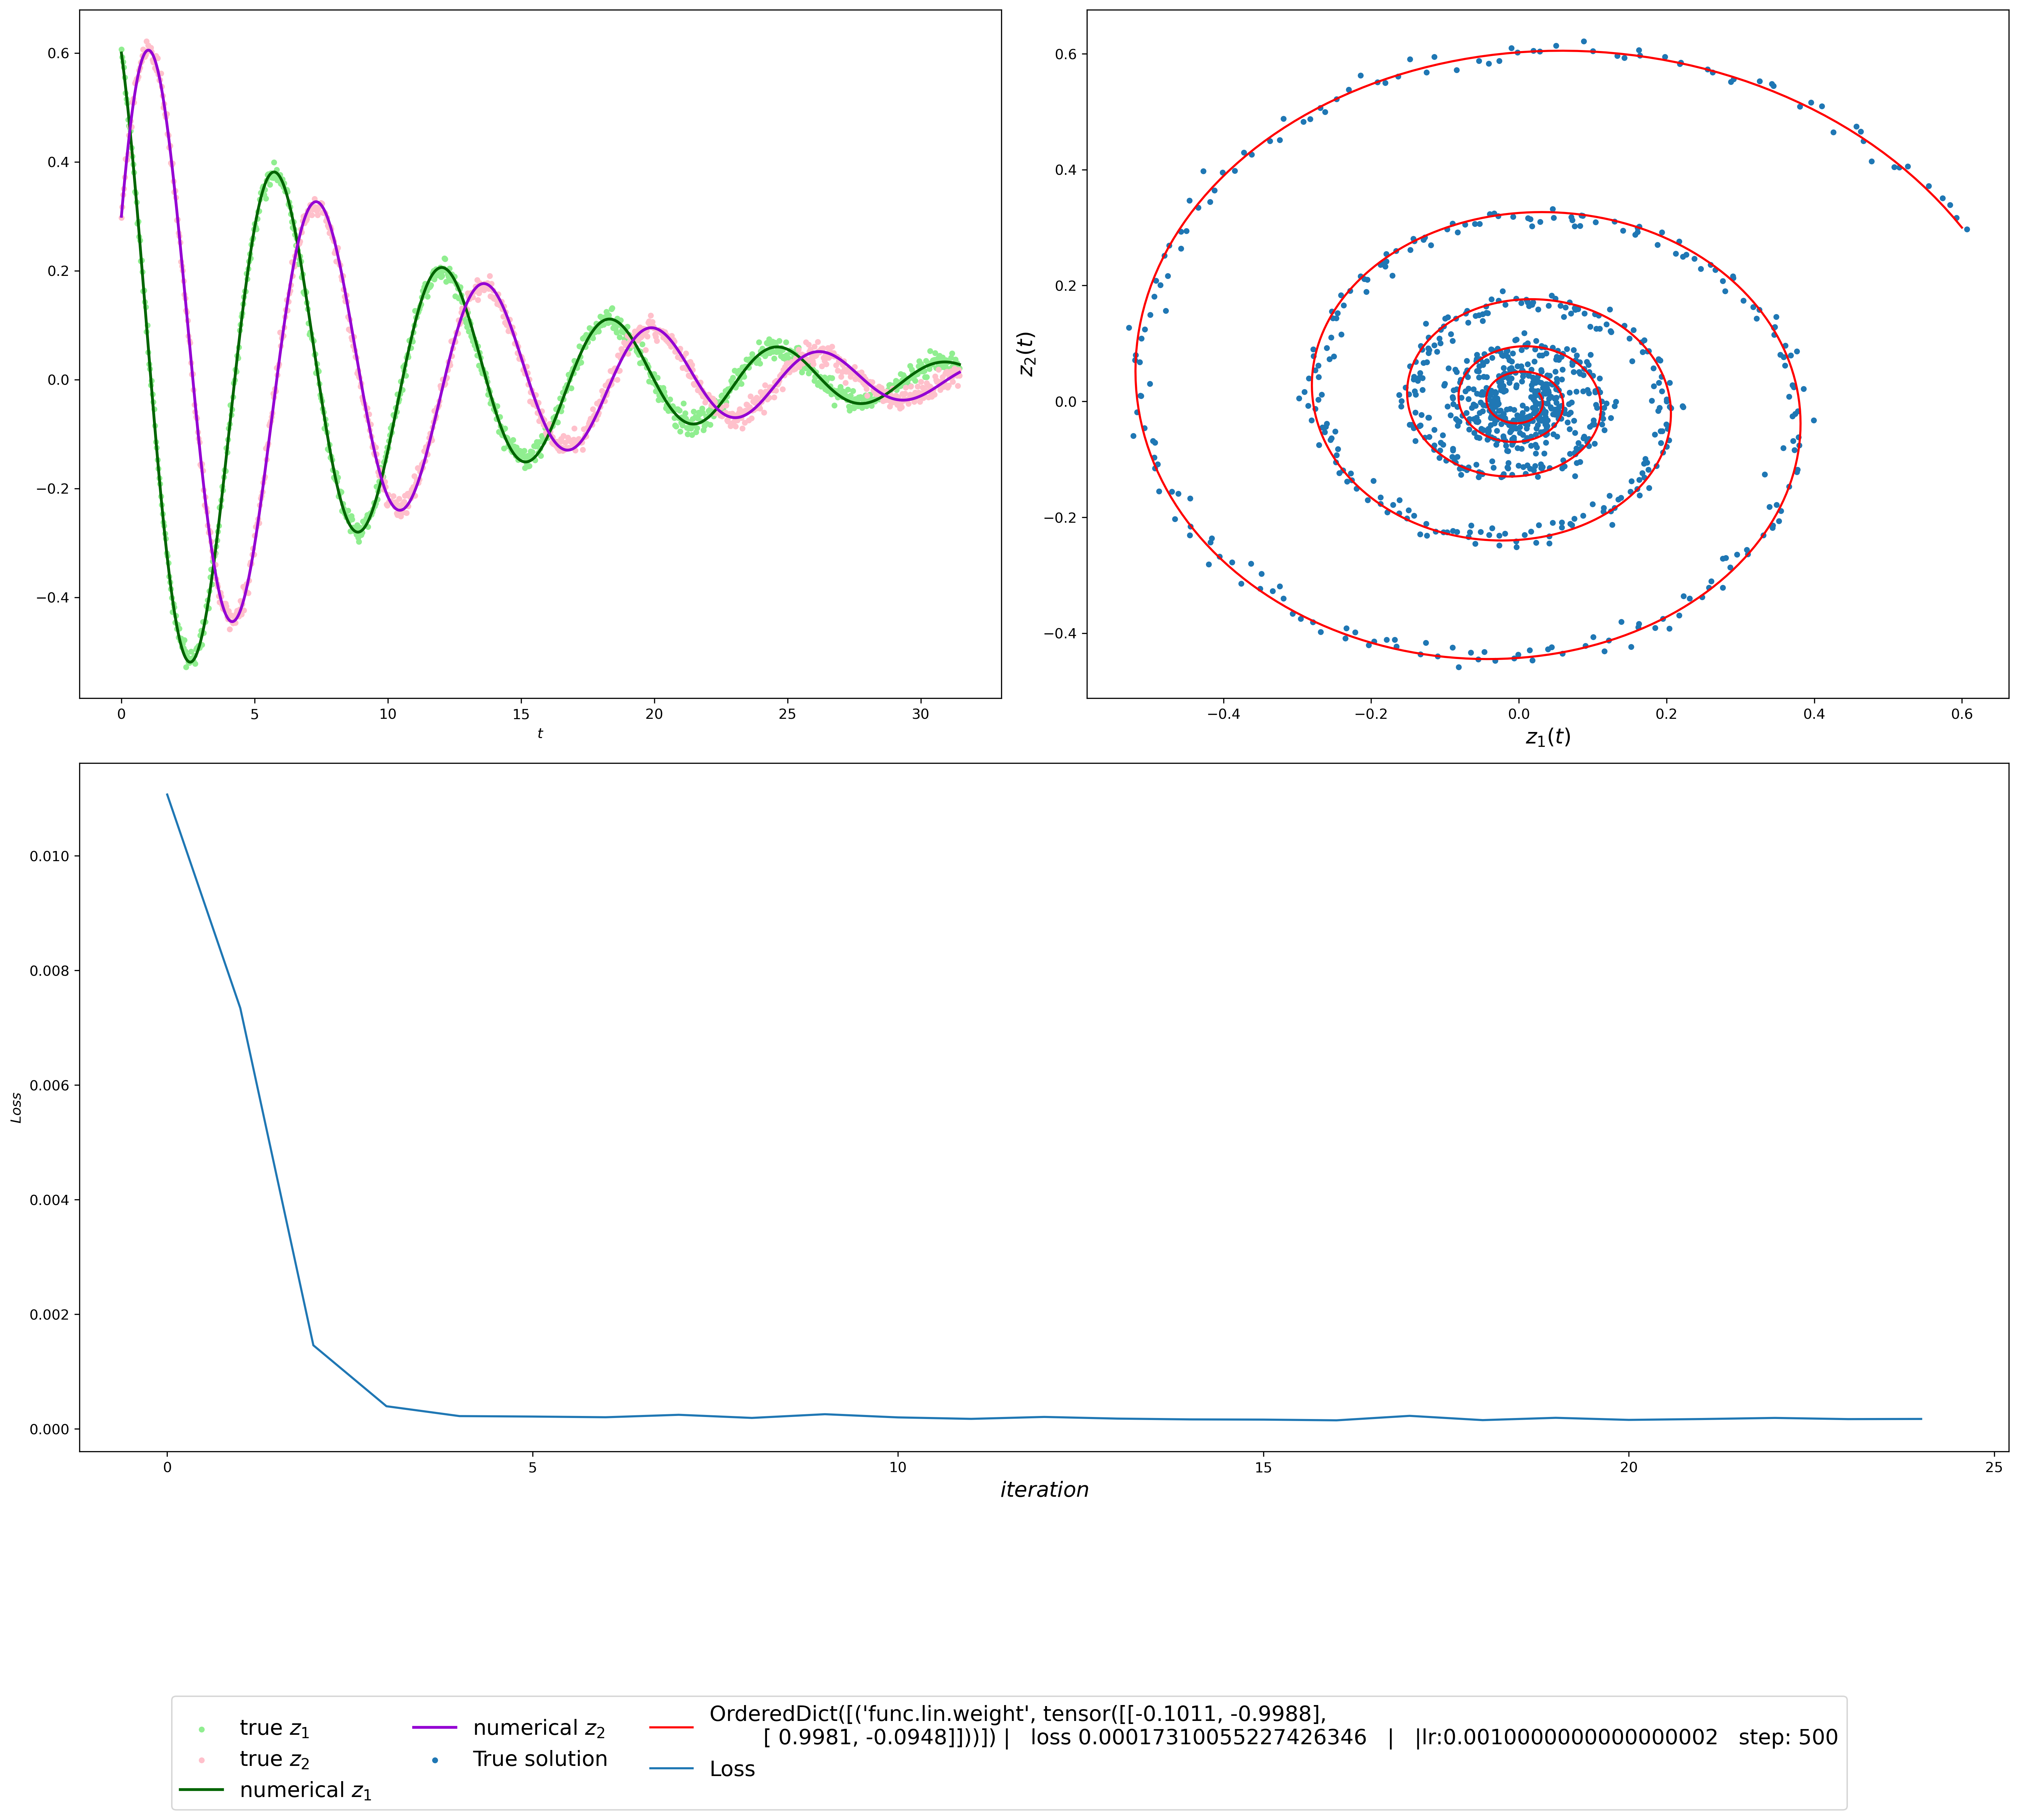

In [36]:
t_max = 6.29*5
n_points = 1000

# Get trajectory of random timespan
min_delta_time = 1.0
max_delta_time = 5.0
max_points_num = 32

#initial point
z0 = Variable(torch.Tensor([[0.6, 0.3]]))

optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200)

conduct_experiment(ode_true=ode_true, 
                   ode_trained=ode_trained,
                   z0=z0,
                   n_steps=500,
                   t_max=t_max, 
                   n_poins=n_points, 
                   min_delta_time=min_delta_time, 
                   max_delta_time=max_delta_time,
                   max_points_num=max_points_num, 
                   wrt_t = True, plot_freq=20, optimizer = optimizer, scheduler = scheduler,
                   desired_loss = 1.3e-4)

#### Difference between true and trained parameters $\theta$
---

In [37]:
np.abs(ode_trained.state_dict()["func.lin.weight"] - ode_true.state_dict()["func.lin.weight"])

tensor([[0.0011, 0.0012],
        [0.0019, 0.0052]])

### 3rd Example
---

$$\frac{dx}{dt} = a_1x + b_1y + c_1e^{-d_1t}$$
$$\frac{dy}{dt} = a_2x + b_2y + c_2e^{-d_2t}$$
$$x(0) = 0 \quad y(0)=0$$
<br>

a1 = 1.11 <br> 
b1 = 2.43 <br>
c1 = -3.66 <br>
d1 = 1.37 <br>
a2 = 2.89 <br>
b2 = -1.97 <br>
c2 = 4.58 <br>
d2 = 2.86 <br>

In [61]:
class MyODEF(ODEF):
    def __init__(self, AB, D, C):
        super(MyODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(AB)
        self.D = nn.Parameter(D)
        self.C = nn.Parameter(C)

    def forward(self, x, t):
        return self.lin(x) + torch.mul(self.C,torch.exp(torch.mul(self.D,-t)))

a1 = 1.11  
b1 = 2.43 
c1 = -3.66 
d1 = 1.37 
a2 = 2.89 
b2 = -1.97 
c2 = 4.58 
d2 = 2.86

class MyExample(MyODEF):
    def __init__(self):
        super(MyExample, self).__init__(Tensor([[a1, a2], [b1, b2]]),  Tensor([[d1,d2]]), Tensor([[c1,c2]]))

class RandomMyODEF(MyODEF):
    def __init__(self):
        super(RandomMyODEF, self).__init__(torch.randn(2, 2)/100,  torch.randn(1, 2)/100, torch.randn(1, 2)/100)

ode_true = NeuralODE(MyExample())
ode_trained = NeuralODE(RandomMyODEF())

In [62]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(20, 15), parameters=None, wrt_t=False,
                      current_loss = None, plot_loss=False, losses=None, step=None, learning_rate = None, idx=None):
    
    # Define a figure
    fig = plt.figure(figsize=figsize, dpi=150)

    # Add subplots to the figure
    ax1 = fig.add_subplot(221)  # 2 rows, 2 columns, plot number 1
    ax2 = fig.add_subplot(222)  # 2 rows, 2 columns, plot number 2
    
    obs, t = to_np(obs), to_np(times)
    z1 = obs[:, :, 0]
    z2 = obs[:, :, 1]
    ax2.scatter(z1, z2, s=10, label="True solution", alpha=0.3)
    if idx is not None: 
        ax2.scatter(z1[idx], z2[idx], s=20, c="darkred",label="True solution")

    z = to_np(trajs)
    ax2.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5, label=f"{parameters} |   loss {current_loss}   |   |lr:{learning_rate}   step: {step}", c="red") 
    
    ax2.set_xlabel("$z_1(t)$", size=15)
    ax2.set_ylabel("$z_2(t)$", size=15)
            
    if wrt_t:
        ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 0], c='lightgreen',s=10, label='true $z_1$')
        ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 1], c='pink',s=10, label='true $z_2$')
        ax1.plot(times.detach().numpy().flatten(), z[:, :, 0], c='darkgreen', linestyle="-",linewidth=2, label='numerical $z_1$')
        ax1.plot(times.detach().numpy().flatten(), z[:, :, 1], c='darkviolet', linestyle="-",linewidth=2, label='numerical $z_2$')
        ax1.set_xlabel('$t$') 
        
    if plot_loss:
        ax3 = fig.add_subplot(212)  # 2 rows, 1 column, plot number 2
        #x = np.arange(ith_step)
        ax3.plot(np.arange(len(losses)), losses, label="Loss")
        ax3.set_xlabel("$iteration$", size=15)
        ax3.set_ylabel("$Loss$", size=15)
            
    
    # Add a general legend below the subplots
    # Show the plot
    plt.tight_layout()
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=15)
    plt.show()

In [63]:
def conduct_experiment(ode_true, ode_trained, z0, n_steps,
                       t_max, n_poins, min_delta_time, max_delta_time, max_points_num, 
                       wrt_t = False, plot_freq=10, optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.05),
                       scheduler = None, desired_loss = 0.01):
    #CREATE THE DATA

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    times_np = np.linspace(0, t_max, num=n_points)
    #print("times_np.shape:", times_np.shape)
    times = torch.from_numpy(times_np).to(z0)
    #print("times:", times.size())
    
    
    
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    #add random noise to the observation tensor
    obs = obs + torch.randn_like(obs) * 0.01

    
    def create_batch():
        """Function to get a mini_batch"""
        
        #t0 = np.random.uniform(0, t_max - max_delta_time)
        #t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)
        t0 = 0
        t1 = t_max
        #creates an index array by selecting a subset of indices from the index_np array
        #by filtering the indices where the corresponding times in times_np fall within the range (t0, t1). 
        #The permutation function shuffles the filtered indices randomly, and [:max_points_num] selects the first max_points_num indices. 
        #Finally, the sorted function is applied to ensure the indices are in ascending order.
        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])
        #print("idx:", idx)
        #print("idx:", idx)

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_, idx

    #Train Neural ODE
    
    
    #initialize the LOSS array
    LOSS = []
    mean_losses = []
    mean_current_loss = np.float64("inf")
    
    for i in range(1, n_steps + 1):

        #generate a mini-batch of observations and corresponding time values
        obs_, ts_, idx = create_batch()
        
        #compute z_ by passing the first observation obs_[0] and its corresponding time values ts_ 
        #through the ode_trained model. The return_whole_sequence=True ensures that the entire trajectory is returned.
        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        
        #compute the loss
        loss = F.mse_loss(z_, obs_.detach())  #The .detach() method is used to detach obs_ from the computational graph,
                                              #preventing gradients from flowing through it during backpropagation.
        LOSS.append(loss.item())
        
        if mean_current_loss <= desired_loss:
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
   
            plot_trajectories(obs=obs, times=times, trajs=z_p, 
                             parameters = ode_trained.state_dict(),
                             wrt_t = True, plot_loss=True, losses=mean_losses,
                             current_loss = mean_current_loss, step=i,
                             learning_rate = lr)  # Display the plot
            
            break
        
        #reset optimizer gradients to zero
        optimizer.zero_grad()
        
        #propagate loss through the computation graph
        loss.backward(retain_graph=True)
        
        #update the model's parameters based on the computed gradients 
        optimizer.step()
        
        lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:  
            scheduler.step()

        if i % plot_freq == 0:
            mean_current_loss = np.mean(LOSS)
            mean_losses.append(mean_current_loss)
            LOSS = []
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
            
            if i == n_steps: 
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                  parameters = ode_trained.state_dict(),
                                  wrt_t = True, plot_loss=True, losses=mean_losses, current_loss = mean_current_loss, step=i,
                                  learning_rate = lr)
            else: 
   
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                 parameters = ode_trained.state_dict(),
                                 wrt_t = True, current_loss=mean_current_loss, step=i, learning_rate = lr,
                                 idx=idx)
   
            clear_output(wait=True)

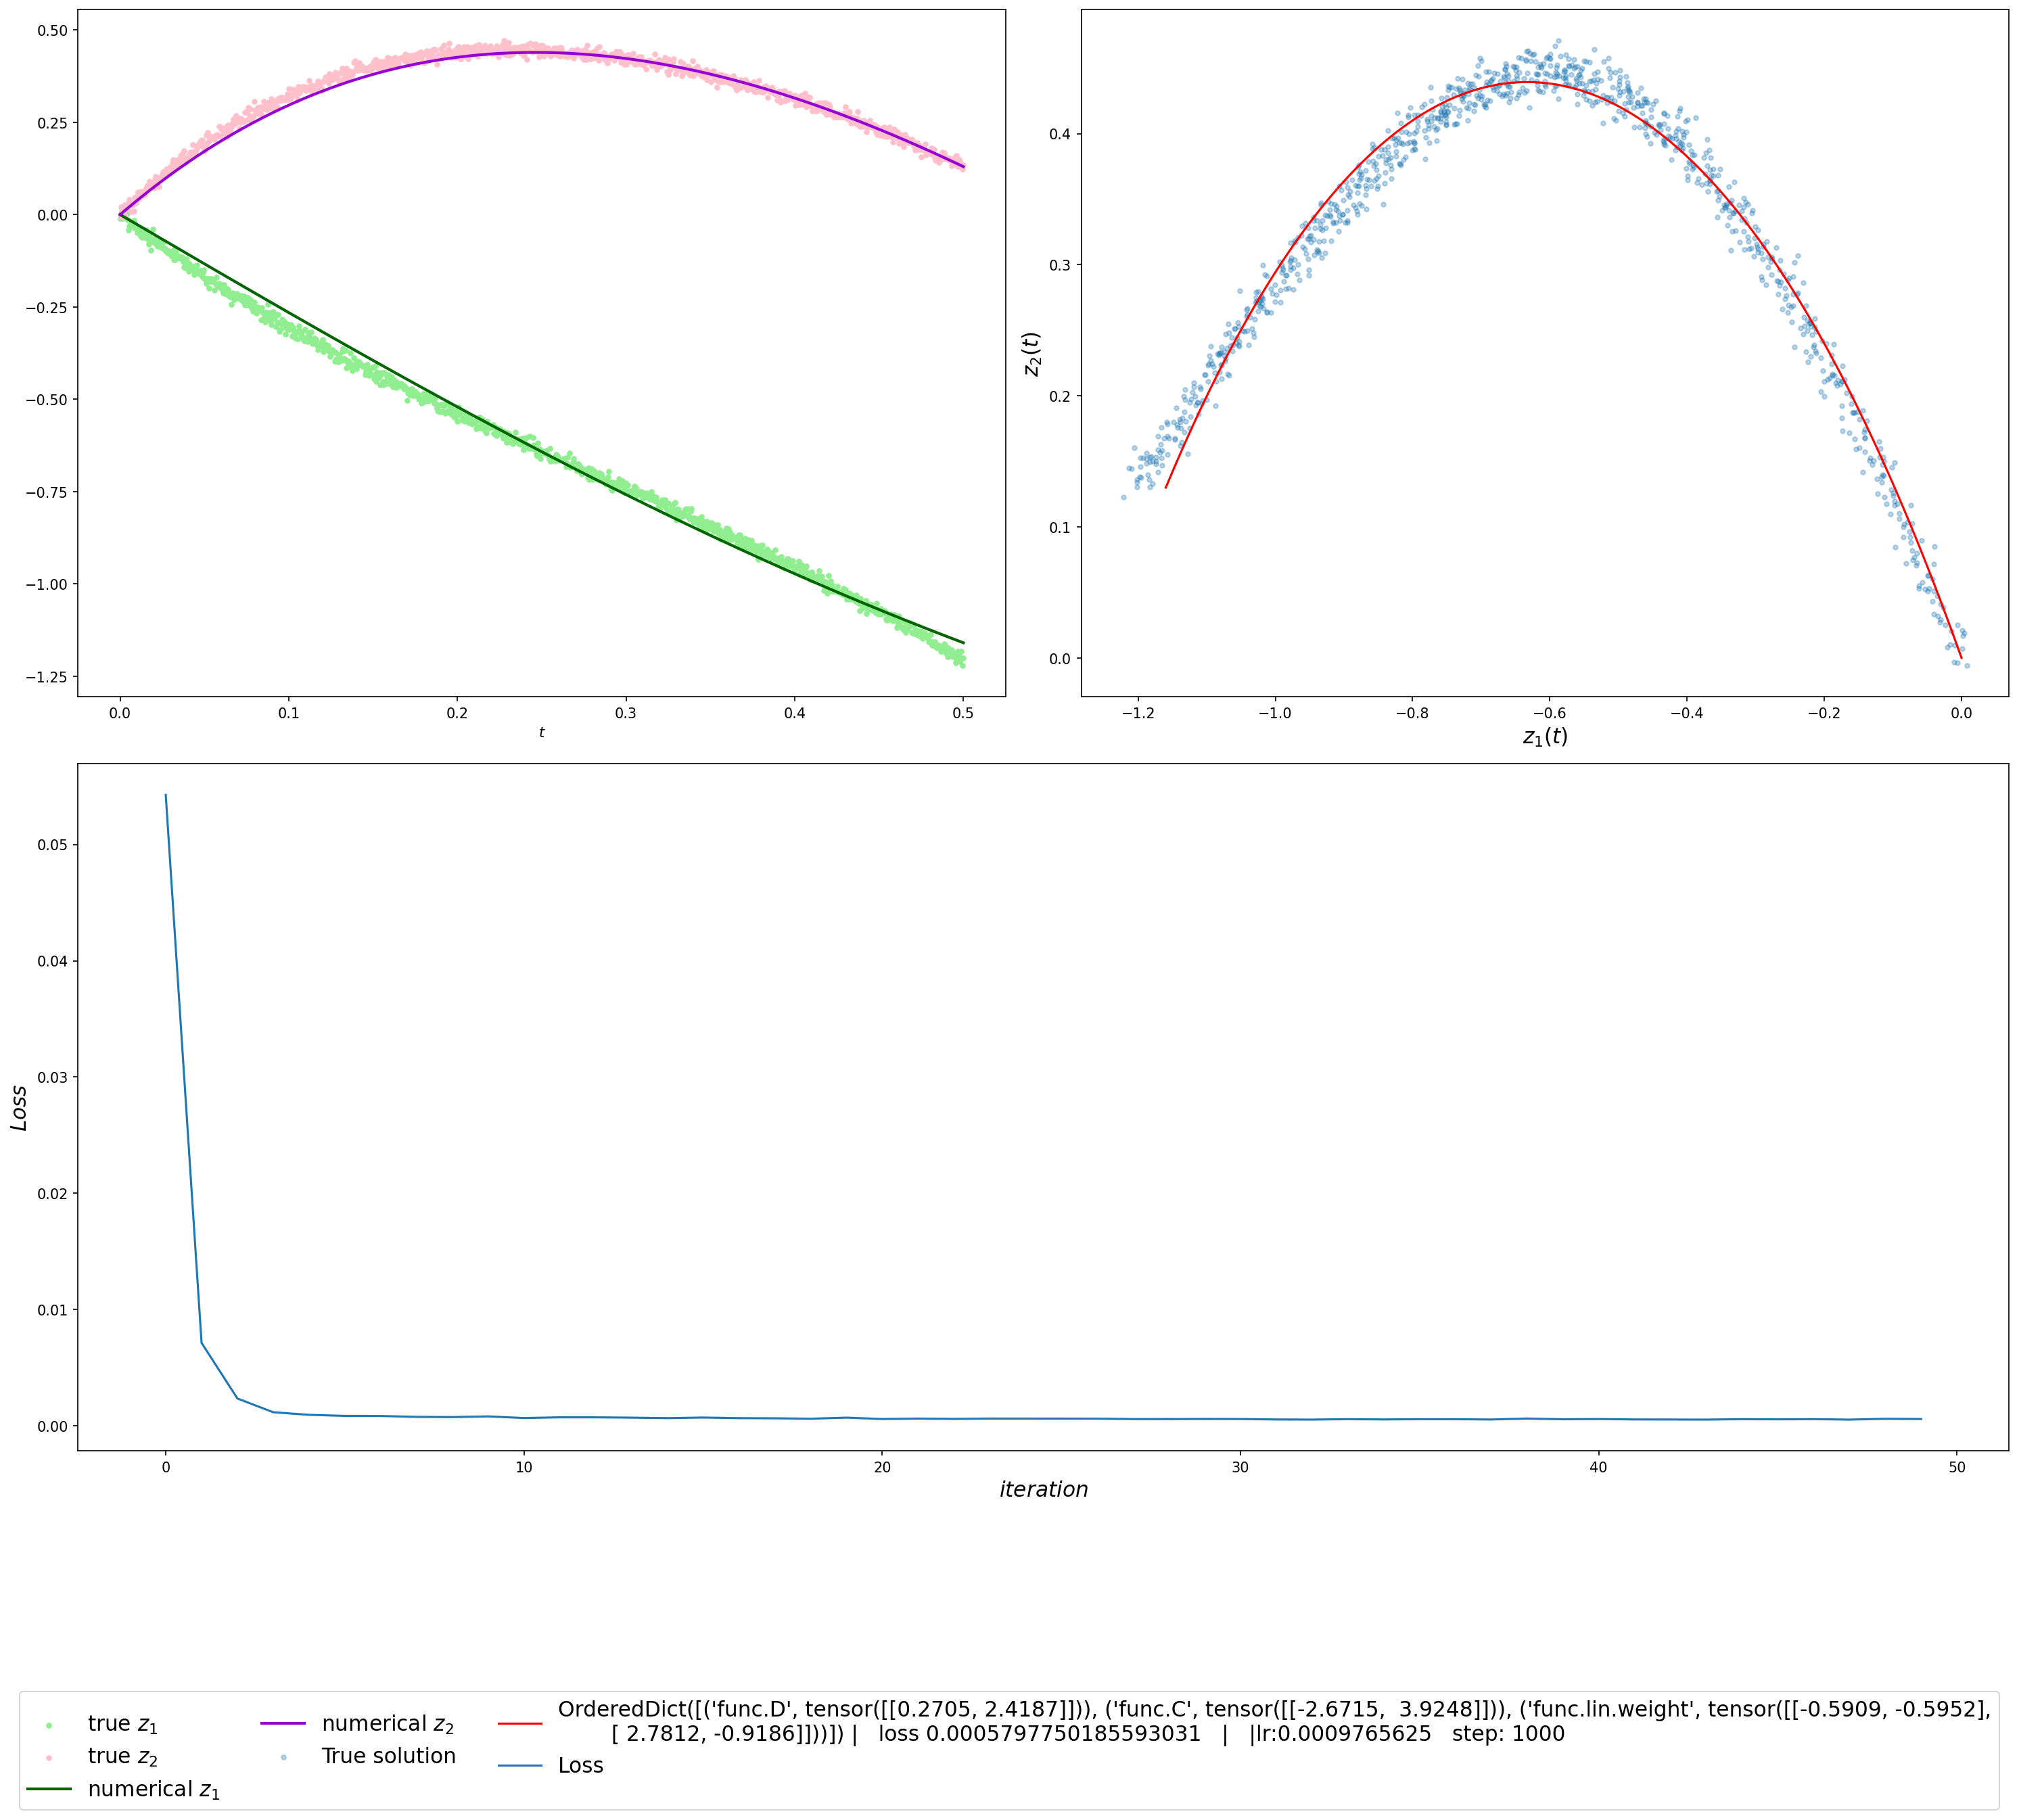

In [64]:
ode_true = NeuralODE(MyExample())
ode_trained = NeuralODE(RandomMyODEF())

t_max = 0.5
n_points = 1000

#get trajectory of random timespan 
min_delta_time = 0
max_delta_time = 0.5
max_points_num = 128

#initial point
z0 = Variable(torch.Tensor([[0, 0]]))

optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)


conduct_experiment(ode_true=ode_true, 
                   ode_trained=ode_trained,
                   z0=z0,
                   n_steps=1000,
                   t_max=t_max, 
                   n_poins=n_points, 
                   min_delta_time=min_delta_time, 
                   max_delta_time=max_delta_time,
                   max_points_num=max_points_num, 
                   wrt_t = True, plot_freq=20, optimizer = optimizer, scheduler = scheduler,
                   desired_loss=1e-4)

#### Difference between true and trained parameters $\theta$
---

In [65]:
import numpy as np

# Given values
a1 = 1.11
b1 = 2.43
c1 = -3.66
d1 = 1.37
a2 = 2.89
b2 = -1.97
c2 = 4.58
d2 = 2.86

# Values from ode_trained
a1_ = ode_trained.state_dict()["func.lin.weight"][0][0].item()
b1_ = ode_trained.state_dict()["func.lin.weight"][0][1].item()
a2_ = ode_trained.state_dict()["func.lin.weight"][1][0].item()
b2_ = ode_trained.state_dict()["func.lin.weight"][1][1].item()
d1_ = ode_trained.state_dict()["func.D"][0][0].item()
d2_ = ode_trained.state_dict()["func.D"][0][1].item()
c1_ = ode_trained.state_dict()["func.C"][0][0].item()
c2_ = ode_trained.state_dict()["func.C"][0][1].item()

# Absolute differences
delt_a1 = np.abs(a1 - a1_)
delt_b1 = np.abs(b1 - b1_)
delt_c1 = np.abs(c1 - c1_)
delt_d1 = np.abs(d1 - d1_)
delt_a2 = np.abs(a2 - a2_)
delt_b2 = np.abs(b2 - b2_)
delt_c2 = np.abs(c2 - c2_)
delt_d2 = np.abs(d2 - d2_)

# Print the absolute differences
print("Absolute Differences:")
print(f"delt_a1 = {delt_a1}")
print(f"delt_b1 = {delt_b1}")
print(f"delt_c1 = {delt_c1}")
print(f"delt_d1 = {delt_d1}")
print(f"delt_a2 = {delt_a2}")
print(f"delt_b2 = {delt_b2}")
print(f"delt_c2 = {delt_c2}")
print(f"delt_d2 = {delt_d2}")

Absolute Differences:
delt_a1 = 1.7008573865890504
delt_b1 = 3.025212519168854
delt_c1 = 0.9885491466522218
delt_d1 = 1.099514002799988
delt_a2 = 0.10879696846008313
delt_b2 = 1.0514238786697387
delt_c2 = 0.6552079486846925
delt_d2 = 0.44126211166381824


### 4th example
---

$$
\begin{align*}
\frac{{dz_1}}{{dt}} &= z_1^3 \cdot (-0.1) + z_2^3 \cdot 2.0 \\
\frac{{dz_2}}{{dt}} &= z_1^3 \cdot (-2.0) + z_2^3 \cdot (-0.1) \\
\end{align*}
$$

$$
\frac{dz}{dt} = 
\begin{bmatrix}
-0.1 & 2.0 \\
-2.0 & -0.1 \\
\end{bmatrix} z^3 
\quad \text{with} \quad  \begin{bmatrix}z_1\\z_2\end{bmatrix}(0) \begin{bmatrix}0.0\\2.0\end{bmatrix}
$$

In [45]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x**3)

class forthExample(LinearODEF):
    def __init__(self):
        super(forthExample, self).__init__(Tensor([[-0.1, 2.], [-2., -0.1]]))

class RandomODEF(LinearODEF):
    def __init__(self):
        super(RandomODEF, self).__init__(torch.randn(2, 2)/10000)

ode_true = NeuralODE(forthExample())
ode_trained = NeuralODE(RandomODEF())

In [46]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(20, 15), parameters=None, wrt_t=False,
                      current_loss = None, plot_loss=False, losses=None, step=None, learning_rate = None, idx=None):
    
        # Define a figure
    fig = plt.figure(figsize=figsize, dpi=150)

    # Add subplots to the figure
    ax1 = fig.add_subplot(221)  # 2 rows, 2 columns, plot number 1
    ax2 = fig.add_subplot(222)  # 2 rows, 2 columns, plot number 2
    
    obs, t = to_np(obs), to_np(times)
    z1 = obs[:, :, 0]
    z2 = obs[:, :, 1]
    ax2.scatter(z1, z2, s=10, label="True solution", alpha=0.3)
    if idx is not None: 
        ax2.scatter(z1[idx], z2[idx], s=20, c="darkred",label="True solution")

    z = to_np(trajs)
    ax2.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5, label=f"{parameters} |   loss {current_loss}   |   |lr:{learning_rate}   step: {step}", c="red") 
    
    ax2.set_xlabel("$z_1(t)$", size=15)
    ax2.set_ylabel("$z_2(t)$", size=15)
            
    if wrt_t:
        ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 0], c='lightgreen',s=10, label='true $z_1$')
        ax1.scatter(times.detach().numpy().flatten(), obs[:, :, 1], c='pink',s=10, label='true $z_2$')
        ax1.plot(times.detach().numpy().flatten(), z[:, :, 0], c='darkgreen', linestyle="-",linewidth=2, label='numerical $z_1$')
        ax1.plot(times.detach().numpy().flatten(), z[:, :, 1], c='darkviolet', linestyle="-",linewidth=2, label='numerical $z_2$')
        ax1.set_xlabel('$t$') 
        
    if plot_loss:
        ax3 = fig.add_subplot(212)  # 2 rows, 1 column, plot number 2
        #x = np.arange(ith_step)
        ax3.plot(np.arange(len(losses)), losses, label="Loss")
        ax3.set_xlabel("$iteration$", size=15)
        ax3.set_ylabel("$Loss$", size=15)
            
    
    # Add a general legend below the subplots
    # Show the plot
    plt.tight_layout()
    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, fontsize=15)
    plt.show()

In [55]:
def conduct_experiment(ode_true, ode_trained, z0, n_steps,
                       t_max, n_poins, min_delta_time, max_delta_time, max_points_num, 
                       wrt_t = False, plot_freq=10, optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.05),
                       scheduler = None, desired_loss = 0.01):
    #CREATE THE DATA

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    times_np = np.linspace(0, t_max, num=n_points)
    #print("times_np.shape:", times_np.shape)
    times = torch.from_numpy(times_np).to(z0)
    #print("times:", times.size())
    
    
    
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    #add random noise to the observation tensor
    obs = obs + torch.randn_like(obs) * 0.01

    
    def create_batch():
        """Function to get a mini_batch"""
        
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)
        
        #creates an index array by selecting a subset of indices from the index_np array
        #by filtering the indices where the corresponding times in times_np fall within the range (t0, t1). 
        #The permutation function shuffles the filtered indices randomly, and [:max_points_num] selects the first max_points_num indices. 
        #Finally, the sorted function is applied to ensure the indices are in ascending order.
        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])
        #print("idx:", idx)
        #print("idx:", idx)

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_, idx

    #Train Neural ODE
    
    
    #initialize the LOSS array
    LOSS = []
    mean_losses = []
    mean_current_loss = np.float64("inf")
    
    for i in range(1, n_steps + 1):

        #generate a mini-batch of observations and corresponding time values
        obs_, ts_, idx = create_batch()
        
        #compute z_ by passing the first observation obs_[0] and its corresponding time values ts_ 
        #through the ode_trained model. The return_whole_sequence=True ensures that the entire trajectory is returned.
        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        
        #compute the loss
        loss = F.mse_loss(z_, obs_.detach())  #The .detach() method is used to detach obs_ from the computational graph,
                                              #preventing gradients from flowing through it during backpropagation.
        LOSS.append(loss.item())
        
        if mean_current_loss <= desired_loss:
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
   
            plot_trajectories(obs=obs, times=times, trajs=z_p, 
                             parameters = ode_trained.state_dict(),
                             wrt_t = True, plot_loss=True, losses=mean_losses,
                             current_loss = mean_current_loss, step=i,
                             learning_rate = lr)  # Display the plot
            
            break
        
        #reset optimizer gradients to zero
        optimizer.zero_grad()
        
        #propagate loss through the computation graph
        loss.backward(retain_graph=True)
        
        #update the model's parameters based on the computed gradients 
        optimizer.step()
        
        lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:  
            scheduler.step()

        if i % plot_freq == 0:
            mean_current_loss = np.mean(LOSS)
            mean_losses.append(mean_current_loss)
            LOSS = []
            
            z_p = ode_trained(z0, times, return_whole_sequence=True)
            
            if i == n_steps: 
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                  parameters = ode_trained.state_dict(),
                                  wrt_t = True, plot_loss=True, losses=mean_losses, current_loss = mean_current_loss, step=i,
                                  learning_rate = lr)
            else: 
   
                plot_trajectories(obs=obs, times=times, trajs=z_p, 
                                 parameters = ode_trained.state_dict(),
                                 wrt_t = True, current_loss=mean_current_loss, step=i, learning_rate = lr,
                                 idx=idx)
   
            clear_output(wait=True)

In [56]:
ode_true = NeuralODE(forthExample())
ode_trained = NeuralODE(RandomODEF())

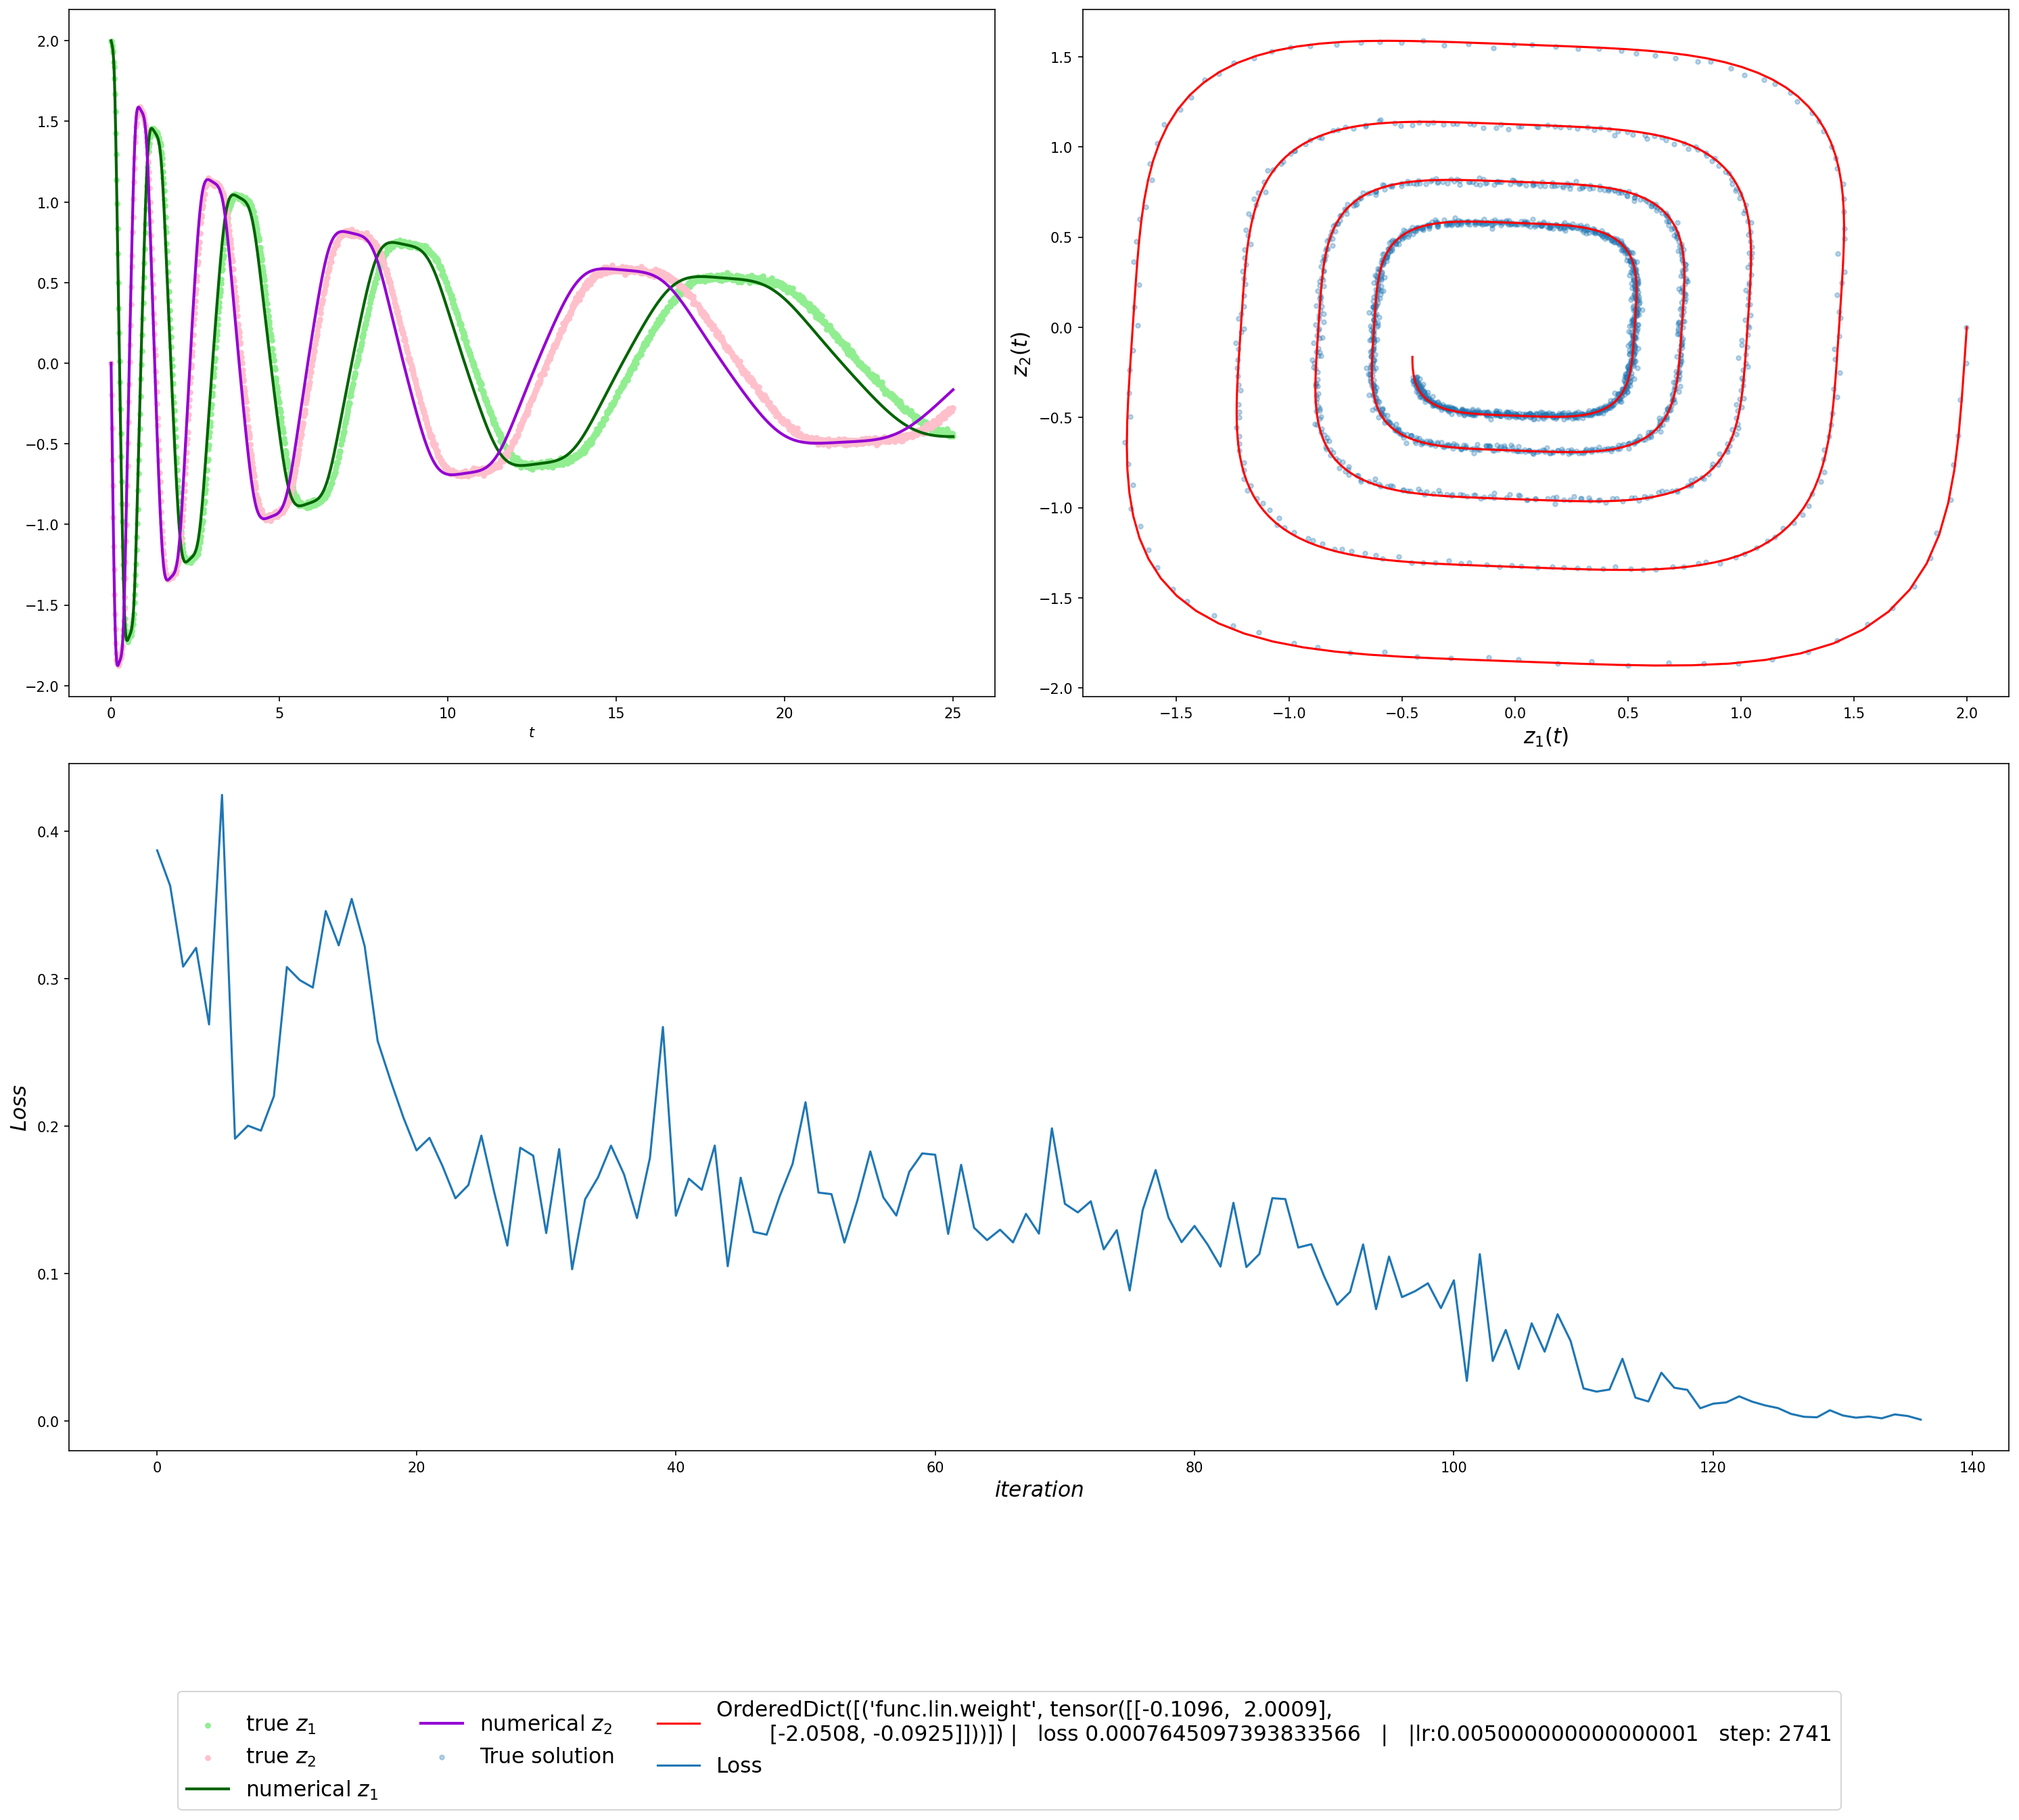

In [57]:
t_max = 25
n_points = 2000

# Get trajectory of random timespan
min_delta_time = 5
max_delta_time =10
max_points_num = 32
#initial point
z0 = Variable(torch.Tensor([[2., 0.]]))

optimizer = torch.optim.AdamW(ode_trained.parameters(), lr=0.5)
# Define the scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400], gamma=0.1)

conduct_experiment(ode_true=ode_true, 
                   ode_trained=ode_trained,
                   z0=z0,
                   n_steps=4000,
                   t_max=t_max, 
                   n_poins=n_points, 
                   min_delta_time=min_delta_time, 
                   max_delta_time=max_delta_time,
                   max_points_num=max_points_num, 
                   wrt_t = True, plot_freq=20, optimizer = optimizer, scheduler = scheduler,
                   desired_loss = 0.0013)

#### Difference between true and trained parameters $\theta$
---

In [58]:
ode_true.state_dict()["func.lin.weight"]

tensor([[-0.1000,  2.0000],
        [-2.0000, -0.1000]])

In [59]:
ode_trained.state_dict()["func.lin.weight"]

tensor([[-0.1096,  2.0009],
        [-2.0508, -0.0925]])

In [60]:
np.abs(ode_trained.state_dict()["func.lin.weight"] - ode_true.state_dict()["func.lin.weight"])

tensor([[0.0096, 0.0009],
        [0.0508, 0.0075]])